In [1]:
import pvl
import json
import ctypes
from plio.spatial import footprint
from plio.io.io_gdal import GeoDataset
import pyproj
import numpy as np
import ogr
import math
from ctypes.util import find_library

import matplotlib.pyplot as plt

from csmapi import csmapi
import requests

from unittest.mock import MagicMock
from unittest.mock import Mock
from unittest.mock import patch

lib = ctypes.CDLL(find_library('usgscsm'))

In [2]:
prime = '/work/users/acpaquette/G03_019459_1800_XN_00N180W.IMG'
not_prime1 = '/work/users/acpaquette/G03_019458_2123_XN_32N157W.IMG'
not_prime2 = '/work/users/acpaquette/G03_019459_1443_XI_35S175W.IMG'
not_prime3= '/work/users/acpaquette/P04_002746_1808_XI_00N002W.IMG'

image = not_prime1

# label = pvl.load(image)
# data = {'label': pvl.dumps(label).decode()}

def get_model(image):
    label = pvl.load(image)
    data = {'label': pvl.dumps(label).decode()}
    
    isd = requests.post('http://pfeffer.wr.usgs.gov/v1/pds/', json=data)
    
    try:
        isd = isd.json()
    except:
        print(isd.status_code)
        return None
    
    isd['IKCODE'] = -1
    isd = csmapi.Isd.loads(isd)
    plugin = csmapi.Plugin.findPlugin('USGS_ASTRO_LINE_SCANNER_PLUGIN')
    model_name = 'USGS_ASTRO_LINE_SCANNER_SENSOR_MODEL'
    
    if plugin.canModelBeConstructedFromISD(isd, model_name):
        model = plugin.constructModelFromISD(isd, model_name)
        
    return model

In [9]:
def compute_line(point1, point2):
    slope = (point2[1] - point1[1]) / (point2[0] - point1[0])
    b = point2[1] - (slope*point2[0])
    
    return slope, b

In [10]:
def generate_latlon_footprint(camera, nnodes=5, semi_major=3396190, semi_minor=3376200, n_points = 20):
    ecef = pyproj.Proj(proj='geocent', a=semi_major, b=semi_minor)
    lla = pyproj.Proj(proj='latlon', a=semi_major, b=semi_minor)

    isize = camera.getImageSize()
    x = np.linspace(0, isize.samp, n_points)
    y = np.linspace(0, isize.line, n_points)
    boundary = [(i,0.) for i in x] + [(isize.samp, i) for i in y[1:]] +\
               [(i, isize.line) for i in x[::-1][1:]] + [(0.,i) for i in y[::-1][1:]]
    ring = ogr.Geometry(ogr.wkbLinearRing)
    wrap_ring = ogr.Geometry(ogr.wkbLinearRing)
    poly = ogr.Geometry(ogr.wkbPolygon)
    
    ll_coords = []
    
    previous_point = None
    
    for i in boundary:
        ipt = csmapi.ImageCoord(*i)
        gnd = camera.imageToGround(ipt, 0)
        lon, lat, alt = pyproj.transform(ecef, lla, gnd.x, gnd.y, gnd.z)
        
        ll_coords.append([(lon + 180) % 360, lat])

    current_ring = ring
    switch_point = None

    for coord in ll_coords:
        
        if previous_point:
            coord_diff = previous_point[0] - coord[0]
            
            if coord_diff > 0 and np.isclose(previous_point[0], 360, rtol = 1e-03) and \
                                  np.isclose(coord[0], 0, atol=1e0, rtol=1e-01):
                slope, b = compute_line(previous_point, coord)
                current_ring.AddPoint(360 - 180, (slope*360 + b))
                current_ring = wrap_ring
                switch_point = 0 - 180, (slope*0 + b)
                current_ring.AddPoint(*switch_point)
                
            elif coord_diff < 0 and np.isclose(previous_point[0], 0, atol=1e0, rtol=1e-01) and \
                                    np.isclose(coord[0], 360, rtol = 1e-03):
                slope, b = compute_line(previous_point, coord)
                current_ring.AddPoint(0 - 180, (slope*0 + b))
                current_ring.AddPoint(*switch_point)
                current_ring = ring
                current_ring.AddPoint(360 - 180, (slope*360 + b))
        
        lat, lon = coord
        current_ring.AddPoint(lat - 180, lon)
        previous_point = coord
    
    poly.AddGeometry(ring)
    poly.AddGeometry(wrap_ring)
    return poly

In [25]:
mock_model = Mock(spec=csmapi.RasterGM)

mock_iv = Mock(spec=csmapi.ImageVector)
mock_iv.samp = 10
mock_iv.line = 10

def create_ecef_coord(imageVector, z):
    ecef_mock = Mock(spec=csmapi.EcefCoord)
    
    ecef_mock.x = imageVector.samp
    ecef_mock.y = imageVector.line
    ecef_mock.z = z
    
    return ecef_mock
    

mock_model.getImageSize = lambda : mock_iv
mock_model.imageToGround = lambda imageVector, z: create_ecef_coord(imageVector, z)

size = 11

x = np.linspace(-180, -179, math.floor(size/2))
x = np.concatenate([np.linspace(179, 180, math.ceil(size/2)), x])
x = np.linspace(170, 172, size)
y = np.linspace(1, 0, size)

lat_lon_boundary = [(i,y[0]) for i in x] + [(x[-1], i) for i in y[1:]] + [(i, y[-1]) for i in x[::-1][1:]] + [(x[0],i) for i in y[::-1][1:]]

x = np.linspace(0, 10, size)
y = np.linspace(0, 10, size)

x_y_boundary = [(i,y[0]) for i in x] + [(x[-1], i) for i in y[1:]] + [(i, y[-1]) for i in x[::-1][1:]] + [(x[0],i) for i in y[::-1][1:]]

@patch.object(pyproj, 'transform')
def map_coords(arg1, arg2, x, y, z, arg3):
    lon, lat = lat_lon_boundary[x_y_boundary.index((x, y))]
    return lon, lat, 0

In [26]:
# model = get_model(prime)

with patch.object(pyproj, 'transform', map_coords) as proj:
    fp = generate_latlon_footprint(mock_model, n_points=11, semi_major=10, semi_minor=10)

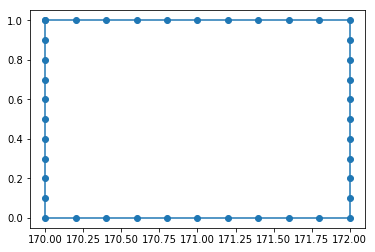

In [27]:
for i in range(fp.GetGeometryCount()):
    latlon_coords = fp.GetGeometryRef(i).GetPoints()
    
    if latlon_coords:
        x = []
        y = []

        for point in latlon_coords:
            x.append(point[0])
            y.append(point[1])
            
        plt.figure(i)
        plt.plot(x, y, marker = "o")

        plt.show()